# BASELINE 코드에 취소 고객 반영해 보기

* 취소 고객 수 컬럼 추가
    - 이용 고객 수 > 이용 건수 : 취소 많음
    - 이용 고객 수 < 이용 건수 : 같은 고객

* 문제
    - 취소 고객 변수를 어떻게 예측에 반영해야 할지 모르겠다. average로 했더니 baseline 점수보다 약간 낮게 나왔다.

In [ ]:
# module import
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import glob

In [ ]:
# path
root_path = '/content/drive/My Drive/TOY/DACON/DACON-JEJU'
data_path = os.path.join(root_path, 'data')
submission_path = os.path.join(root_path, 'submission')

In [ ]:
"# load data
data = pd.read_csv(os.path.join(data_path, '201901-202003.csv'))

In [ ]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [ ]:
data.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

In [ ]:
data['REG_YYMM'].unique()

array([201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
       201909, 201910, 201911, 201912, 202001, 202002, 202003])

In [ ]:
# 데이터 전처리
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 결측치 채우기
# data = data.fillna('')

# 년, 월 나누기
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data.drop('REG_YYMM', axis=1, inplace=True)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [ ]:
# 결측치 있는 열 삭제
df = data.drop(columns=['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,건강보조식품 소매업,강원,20s,1,1,4,311200,4,2019,1
1,강원,건강보조식품 소매업,강원,30s,1,2,7,1374500,8,2019,1
2,강원,건강보조식품 소매업,강원,30s,2,2,6,818700,6,2019,1
3,강원,건강보조식품 소매업,강원,40s,1,3,4,1717000,5,2019,1
4,강원,건강보조식품 소매업,강원,40s,1,4,3,1047300,3,2019,1


In [ ]:
# 시도별, 업종별, 고객 지역별, 나이대별, 성별, FLC, year, month별 합으로 그룹화 : 범주형 변수별로 묶은 것.
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3


* 취소 건수, 단골 고객 건수 확인

In [ ]:
# 이용 고객 수 - 이용 건수
df['CANCEL'] = df['CSTMR_CNT'] - df['CNT'] # 0보다 크면 단골 많음, 0보다 작으면 취소 많음.
def cancel_fn(x):
    if x > 0:
        return "단골"
    elif x == 0:
        return "평범"
    else:
        return "취소"
df['CANCEL'] = df['CANCEL'].apply(lambda x: cancel_fn(x))

In [ ]:
print(df['CANCEL'].value_counts())
df.head()

취소    887592
평범    161230
단골      8572
Name: CANCEL, dtype: int64


,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT,CANCEL
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4,평범
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3,평범
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3,평범
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3,평범
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3,평범


In [ ]:
# 열 삭제: CSTMR_CNT, CNT
df.drop(columns=['CSTMR_CNT', 'CNT'], axis=1, inplace=True)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT,CANCEL
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,311200,평범
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,605000,평범
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,139000,평범
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,27500,평범
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,395500,평범


In [ ]:
# 인코딩
print(df.info())

dtypes = df.dtypes # 인덱스가 col, 값이 데이터타입.
encoders = {} # 인코딩해야 할 객체 dict로 저장.

for col in df.columns:
    if str(dtypes[col]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[col])
        encoders[col] = encoder # 인코더 객체 저장해 놓고 나중에.

df_num = df.copy()
for col in encoders.keys():
    encoder = encoders[col]
    print(col, encoder.classes_)
    df_num[col] = encoder.transform(df[col]) # 바꾸기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057394 entries, 0 to 1057393
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   CARD_SIDO_NM  1057394 non-null  object
 1   STD_CLSS_NM   1057394 non-null  object
 2   HOM_SIDO_NM   1057394 non-null  object
 3   AGE           1057394 non-null  object
 4   SEX_CTGO_CD   1057394 non-null  int64 
 5   FLC           1057394 non-null  int64 
 6   year          1057394 non-null  int64 
 7   month         1057394 non-null  int64 
 8   AMT           1057394 non-null  int64 
 9   CANCEL        1057394 non-null  object
dtypes: int64(5), object(5)
memory usage: 80.7+ MB
None
CARD_SIDO_NM ['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']
STD_CLSS_NM ['건강보조식품 소매업' '골프장 운영업' '과실 및 채소 소매업' '관광 민예품 및 선물용품 소매업'
 '그외 기타 분류안된 오락관련 서비스업' '그외 기타 스포츠시설 운영업' '그외 기타 종합 소매업' '기타 대형 종합 소매업'
 '기타 수상오락 서비스업' '기타 외국식 음식점업' '기타 주점업' '기타음식료품위주종합소매업' '내항 여

In [ ]:
display(df_num)

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT,CANCEL
0,0,0,0,1,1,1,2019,1,311200,2
1,0,0,0,1,1,1,2019,2,605000,2
2,0,0,0,1,1,1,2019,6,139000,2
3,0,0,0,1,1,1,2019,8,27500,2
4,0,0,0,1,1,1,2019,9,395500,2
...,...,...,...,...,...,...,...,...,...,...
1057389,16,40,16,6,2,5,2019,3,148000,1
1057390,16,40,16,6,2,5,2019,5,329800,1
1057391,16,40,16,6,2,5,2019,10,557800,2
1057392,16,40,16,6,2,5,2019,12,247800,2


In [ ]:
# feature, target 설정
train_num = df_num.sample(frac=1, random_state=0)
# train_features = train_num.drop(columns=['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
X_train = train_num.drop(columns=['AMT'], axis=1) # 훈련 데이터
y_train = np.log1p(train_num['AMT']) # 라벨

In [ ]:
# 훈련
model = RandomForestRegressor(n_jobs=-1, random_state=0, verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=1, warm_start=False)

[0.21075243 0.17002586 0.20721121 0.09360946 0.02187643 0.07040444
 0.00809804 0.03583637 0.18218576]


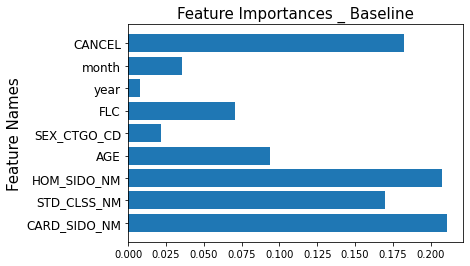

In [ ]:
# 특성 중요도
feature_importances = model.feature_importances_
print(feature_importances)

feature_names = list(X_train.columns)
n_features = X_train.shape[1]
idx = np.arange(n_features)

plt.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, size=12)
plt.title('Feature Importances', size=15)
plt.ylabel('Feature Names', size=15)
plt.show()

In [ ]:
# 예측 템플릿
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = df_num['HOM_SIDO_NM'].unique()
AGEs = df_num['AGE'].unique()
SEX_CTGO_CDs = df_num['SEX_CTGO_CD'].unique()
FLCs = df_num['FLC'].unique()
CANCELs = df_num['CANCEL'].unique() # 추가
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for CANCEL in CANCELs: # 추가
                            for year in years:
                                for month in months:
                                    temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, CANCEL, year, month])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CANCEL', 'year', 'month'])
display(temp)

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CANCEL,year,month
0,0,0,0,1,1,1,2,2020,4
1,0,0,0,1,1,1,2,2020,7
2,0,0,0,1,1,1,1,2020,4
3,0,0,0,1,1,1,1,2020,7
4,0,0,0,1,1,1,0,2020,4
...,...,...,...,...,...,...,...,...,...
4976575,16,30,14,0,2,5,2,2020,7
4976576,16,30,14,0,2,5,1,2020,4
4976577,16,30,14,0,2,5,1,2020,7
4976578,16,30,14,0,2,5,0,2020,4


* 예측 시 문제가 CANCEL이 많은 업종인지 아닌지에 따라서 달라진다.
    - 그냥 말 그대로 평균을 내 보자.

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred) # 지수함수 변환

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.2s finished


In [ ]:
print(pred)
print(len(pred))

[130338.81191784 130338.81191784 130338.81191784 ... 112797.84027518
 112797.84027518 112797.84027518]
4976580


In [ ]:
temp['PRED'] = pd.Series(pred)
display(temp)

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CANCEL,year,month,PRED
0,0,0,0,1,1,1,2,2020,4,130338.811918
1,0,0,0,1,1,1,2,2020,7,130338.811918
2,0,0,0,1,1,1,1,2020,4,130338.811918
3,0,0,0,1,1,1,1,2020,7,130338.811918
4,0,0,0,1,1,1,0,2020,4,130338.811918
...,...,...,...,...,...,...,...,...,...,...
4976575,16,30,14,0,2,5,2,2020,7,112797.840275
4976576,16,30,14,0,2,5,1,2020,4,112797.840275
4976577,16,30,14,0,2,5,1,2020,7,112797.840275
4976578,16,30,14,0,2,5,0,2020,4,112797.840275


In [ ]:
temp_df = temp.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month'], as_index=False)['PRED'].mean()
temp_df

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,PRED
0,0,0,0,0,1,1,2020,4,37656.481849
1,0,0,0,0,1,1,2020,7,37656.481849
2,0,0,0,0,1,2,2020,4,37740.229814
3,0,0,0,0,1,2,2020,7,37740.229814
4,0,0,0,0,1,3,2020,4,92024.378333
...,...,...,...,...,...,...,...,...,...
1658855,16,40,16,6,2,3,2020,7,245931.632171
1658856,16,40,16,6,2,4,2020,4,273755.044804
1658857,16,40,16,6,2,4,2020,7,273755.044804
1658858,16,40,16,6,2,5,2020,4,311263.080672


In [ ]:
temp_df['AMT'] = temp_df['PRED'].apply(lambda x: np.round(x, 0))
temp_df

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,PRED,AMT
0,0,0,0,0,1,1,2020,4,37656.481849,37656.0
1,0,0,0,0,1,1,2020,7,37656.481849,37656.0
2,0,0,0,0,1,2,2020,4,37740.229814,37740.0
3,0,0,0,0,1,2,2020,7,37740.229814,37740.0
4,0,0,0,0,1,3,2020,4,92024.378333,92024.0
...,...,...,...,...,...,...,...,...,...,...
1658855,16,40,16,6,2,3,2020,7,245931.632171,245932.0
1658856,16,40,16,6,2,4,2020,4,273755.044804,273755.0
1658857,16,40,16,6,2,4,2020,7,273755.044804,273755.0
1658858,16,40,16,6,2,5,2020,4,311263.080672,311263.0


In [ ]:
temp_df['REG_YYMM'] = temp_df['year'] * 100 + temp_df['month']
temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
display(temp_df)

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,0,0,127024001.0
1,202004,0,1,203635812.0
2,202004,0,2,137487611.0
3,202004,0,3,91015321.0
4,202004,0,4,227906843.0
...,...,...,...,...
1389,202007,16,36,37895023.0
1390,202007,16,37,52508377.0
1391,202007,16,38,107541826.0
1392,202007,16,39,190805673.0


In [ ]:
# 범주형 변수 디코딩
temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])
display(temp_df)

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,127024001.0
1,202004,강원,골프장 운영업,203635812.0
2,202004,강원,과실 및 채소 소매업,137487611.0
3,202004,강원,관광 민예품 및 선물용품 소매업,91015321.0
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,227906843.0
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,37895023.0
1390,202007,충북,한식 음식점업,52508377.0
1391,202007,충북,호텔업,107541826.0
1392,202007,충북,화장품 및 방향제 소매업,190805673.0


In [ ]:
submission_path

'/content/drive/My Drive/TOY/DACON/DACON-JEJU/submission'

In [ ]:
# 제출 파일 순번
def return_sub_num():
    files = glob.glob(f"{submission_path}/*.csv")
    if len(files) == 0:
        return '001'
    else:
        return str(int(files[-1].split('.')[0][-3:])+1).zfill(3)

In [ ]:
# 제출파일 만들기
submission = pd.read_csv(f"{data_path}/submission.csv", index_col=0)
submission = submission.drop(columns=['AMT'], axis=1)
submission = submission.merge(temp_df, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'

num = return_sub_num()
print(num)

display(submission)
submission.to_csv(f"{submission_path}/submission_{num}.csv", encoding='utf-8-sig')

001


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,127024001.0
1,202004,강원,골프장 운영업,203635812.0
2,202004,강원,과실 및 채소 소매업,137487611.0
3,202004,강원,관광 민예품 및 선물용품 소매업,91015321.0
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,227906843.0
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,37895023.0
1390,202007,충북,한식 음식점업,52508377.0
1391,202007,충북,호텔업,107541826.0


In [ ]:
return_sub_num()

'002'